# Project Telecom Customer Retention

## Table of Contents:

* [Project description](#description)
* [Description of the data](#data)
* [Open the data file](#open)
* [Data Reading and Data Cleaning](#read)
* [EDA](#EDA)
    * [Response Variable](#ResponseVariable)
    * [Demographic Information](#Demographic)
    * [Customer Account Information — Categorical variables](#CustomerAccount)
    * [Customer Account Information — Numerical variables](#CustomerAccountNumerical)
    * [Services Information](#ServicesInformation)
    * [Feature Importance](#Featureimportance)
    * [Customer Exception](#customerexception)
* [Work Plan](#Work_Plan)
* [Prepare data for machine learning](#Prepare)
    * [Feature Engineering](#Engineering)
        * [Label Encoding](#LabelEncoding)
        * [One-Hot Encoding](#One-HotEncoding)
    * [Checking for Outliers](#outliers)
    * [Spliting the Data](#spliting)
* [Models](#models)
    * [Random forest classfier](#Randomforest)
    * [Gradient Boosting](#GradientBoosting)
        * [Gradient Boosting Classifier](#GradientBoostingClassifier)
        * [Lightgbm Classifier](#LightgbmClassifier)
        * [CatBoost Classifier](#CatBoostClassifier)
    * [Improving the Model](#improving)
        * [Resampling](#resampling)
        * [Eliminating features of less importance](#Eliminating)
    * [Baseline model for sanity check](#sanity)
* [Conclusion](#Conclusion)
* [Solution Report](#Solution)

## Project description <a class="anchor" id="description"></a>

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

#### Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

##### Target feature: 
the `'EndDate'` column equals `'No'`.

Primary metric: AUC-ROC.

Additional metric: Accuracy.

### Description of the data  <a class="anchor" id="data"></a>

The data consists of files obtained from different sources:

- contract — contract information:
    * begindate: the date where the  customer registered to the service  
    * enddate: the target - the date where the  customer exited to the service or it didn't -'No'
    * type: Indicates the customer’s current contract type (Month-to-Month, One year, Two year).
    * PaperlessBilling: Whether the client has paperless billing or not (Yes, No).
    * PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit Card (automatic)).
    * MontlyCharges: The amount charged to the customer monthly (Multiple different numeric values).
    * TotalCharges: The total amount charged to the customer (Multiple different numeric values).
    
- personal — the client's personal data:
    * gender: Whether the client is a female or a male (Female, Male).
    * SeniorCitizen: Whether the client is a senior citizen or not ( 0, 1).
    * Partner: Whether the client has a partner or not (Yes, No).
    * Dependents: Whether the client has dependents or not (Yes, No).
    
- internet — information about Internet services:
    * InternetServices: Whether the client is subscribed to Internet service with the company (DSL, Fiber optic, No)
    * OnlineSecurity: Whether the client has online security or not (No internet service, No, Yes).
    * OnlineBackup: Whether the client has online backup or not (No internet service, No, Yes).
    * DeviceProtection: Whether the client has device protection or not (No internet service, No, Yes).
    * TechSupport: Whether the client has tech support or not (No internet service, No, Yes).
    * StreamingTV: Whether the client has streaming TV or not (No internet service, No, Yes).
    * StreamingMovies: Whether the client has streaming movies or not (No internet service, No, Yes).
    
- phone.csv — information about telephone services:
    * MultipleLines: Whether the client has multiple lines or not (No phone service, No, Yes).

In each file, the column `customerID` contains a unique code assigned to each client.

## Open the data file<a class="anchor" id='open'></a>

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy.random import RandomState
from pprint import pprint
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.preprocessing import StandardScaler
import time
from statistics import mean
import catboost as cb
from sklearn.preprocessing import OrdinalEncoder
from catboost import Pool, cv
import math
import lightgbm as lgb
import xgboost as xgb
import sklearn.metrics as metrics
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [2]:
#openfiles from directory
try:
    df_contract = pd.read_csv('contract.csv')
    df_internet = pd.read_csv('internet.csv')
    df_personal = pd.read_csv('personal.csv')
    df_phone = pd.read_csv('phone.csv')
except:
    print("Something went wrong when opening the file")

### Data Reading and Data Cleaning<a class="anchor" id="read"></a>

In [3]:
#changing features names to lowercase
df_contract.columns= df_contract.columns.str.lower()
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
#changing totalcharges to float data type
df_contract['totalcharges'] =  pd.to_numeric(df_contract['totalcharges'],errors = 'coerce')

In [5]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [6]:
#checking for missing values
report = df_contract.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df_contract.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

missing_values  % of total
totalcharges                  11         0.0
customerid                     0         0.0
begindate                      0         0.0
enddate                        0         0.0
type                           0         0.0
paperlessbilling               0         0.0
paymentmethod                  0         0.0
monthlycharges                 0         0.0

In [7]:
#there are 11 missing values that need to be dropped
df_contract = df_contract.dropna(subset=['totalcharges'])


In [8]:
print("duplicates number: {}".format(df_contract.duplicated().sum()))

duplicates number: 0


In [9]:
#checking for missing values
report = df_contract.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df_contract.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

missing_values  % of total
customerid                     0         0.0
begindate                      0         0.0
enddate                        0         0.0
type                           0         0.0
paperlessbilling               0         0.0
paymentmethod                  0         0.0
monthlycharges                 0         0.0
totalcharges                   0         0.0

In [10]:
#changing feature  to lowercase
df_contract['type'] = df_contract['type'].str.lower()
df_contract['paymentmethod'] = df_contract['paymentmethod'].str.lower()

In [11]:
#changing feature data type to date type
df_contract["begindate"] = pd.to_datetime(df_contract['begindate'], format='%Y-%m-%d')

In [12]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7032 non-null   object        
 1   begindate         7032 non-null   datetime64[ns]
 2   enddate           7032 non-null   object        
 3   type              7032 non-null   object        
 4   paperlessbilling  7032 non-null   object        
 5   paymentmethod     7032 non-null   object        
 6   monthlycharges    7032 non-null   float64       
 7   totalcharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 494.4+ KB


In [13]:
#changing features names to lowercase
df_internet.columns= df_internet.columns.str.lower()
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
#changing feature  to lowercase
df_internet['internetservice'] = df_internet['internetservice'].str.lower()

In [15]:
df_internet.sample(5)

customerid internetservice onlinesecurity onlinebackup deviceprotection  \
3768  6478-HRRCZ             dsl            Yes          Yes               No   
671   6982-SSHFK             dsl             No           No               No   
384   4431-EDMIQ             dsl            Yes          Yes              Yes   
1737  7036-TYDEC     fiber optic             No           No              Yes   
3389  2674-MLXMN     fiber optic             No          Yes               No   

     techsupport streamingtv streamingmovies  
3768         Yes          No             Yes  
671           No          No              No  
384          Yes         Yes              No  
1737         Yes         Yes             Yes  
3389          No         Yes             Yes

In [16]:
#checking for missing values
report = df_internet.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df_internet.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

missing_values  % of total
customerid                     0         0.0
internetservice                0         0.0
onlinesecurity                 0         0.0
onlinebackup                   0         0.0
deviceprotection               0         0.0
techsupport                    0         0.0
streamingtv                    0         0.0
streamingmovies                0         0.0

In [17]:
print("duplicates number: {}".format(df_internet.duplicated().sum()))

duplicates number: 0


In [18]:
#changing features names to lowercase
df_personal.columns= df_personal.columns.str.lower()
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [19]:
df_personal.sample(5)

customerid  gender  seniorcitizen partner dependents
5217  5018-HEKFO  Female              0      No         No
4610  2889-FPWRM    Male              0     Yes         No
1793  4193-IBKSW    Male              0     Yes        Yes
4869  1384-RCUXW    Male              0      No         No
2687  5213-TWWJU    Male              0      No         No

In [20]:
#checking for missing values
report = df_personal.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df_personal.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

missing_values  % of total
customerid                  0         0.0
gender                      0         0.0
seniorcitizen               0         0.0
partner                     0         0.0
dependents                  0         0.0

In [21]:
print("duplicates number: {}".format(df_internet.duplicated().sum()))

duplicates number: 0


In [22]:
#changing features names to lowercase
df_phone.columns= df_phone.columns.str.lower()
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [23]:
df_phone.sample(5)

customerid multiplelines
3876  3814-MLAXC           Yes
6128  5893-KCLGT            No
4857  4919-IKATY           Yes
5603  2925-VDZHY           Yes
1389  8096-LOIST            No

In [24]:
#checking for missing values
report = df_phone.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df_phone.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

missing_values  % of total
customerid                  0         0.0
multiplelines               0         0.0

In [25]:
print("duplicates number: {}".format(df_phone.duplicated().sum()))

duplicates number: 0


In [26]:
#mergeing data sets
total_df = pd.merge(df_contract, df_personal, on=['customerid'])

In [27]:
#checking for missing values
report = total_df.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / total_df.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

missing_values  % of total
customerid                     0         0.0
begindate                      0         0.0
enddate                        0         0.0
type                           0         0.0
paperlessbilling               0         0.0
paymentmethod                  0         0.0
monthlycharges                 0         0.0
totalcharges                   0         0.0
gender                         0         0.0
seniorcitizen                  0         0.0
partner                        0         0.0
dependents                     0         0.0

In [28]:
total_df.sample(5)

customerid  begindate enddate            type paperlessbilling  \
1936  9261-WDCAF 2019-11-01      No  month-to-month               No   
1669  2808-CHTDM 2018-03-01      No        two year               No   
6664  6258-NGCNG 2019-07-01      No  month-to-month               No   
159   7554-NEWDD 2019-04-01      No        two year               No   
4558  8375-KVTHK 2014-06-01      No        one year              Yes   

                  paymentmethod  monthlycharges  totalcharges  gender  \
1936               mailed check           54.65        189.10    Male   
1669               mailed check           25.10        611.45  Female   
6664               mailed check           23.50        173.00    Male   
159   bank transfer (automatic)           25.70        251.60    Male   
4558           electronic check          100.30       6754.35    Male   

      seniorcitizen partner dependents  
1936              0      No         No  
1669              0     Yes        Yes  
6664              0      No         No  
159               0      No         No  
4558              0     Yes         No

In [29]:
#mergeing data sets
total_df_2 = pd.merge(total_df, df_internet, on=['customerid'], how='left')

In [31]:
all_df = pd.merge(total_df_2, df_phone, on=['customerid'], how='left')

In [32]:
all_df.sample(5)

customerid  begindate              enddate            type  \
4600  0813-TAXXS 2015-07-01                   No        two year   
896   4315-MURBD 2018-11-01  2019-11-01 00:00:00  month-to-month   
1109  7627-JKIAZ 2016-09-01  2019-10-01 00:00:00  month-to-month   
2604  4446-BZKHU 2014-09-01  2019-10-01 00:00:00  month-to-month   
6088  9114-DPSIA 2014-02-01                   No        two year   

     paperlessbilling              paymentmethod  monthlycharges  \
4600              Yes  bank transfer (automatic)           77.80   
896               Yes  bank transfer (automatic)           98.90   
1109              Yes    credit card (automatic)           78.95   
2604              Yes           electronic check          105.55   
6088               No    credit card (automatic)           81.00   

      totalcharges  gender  seniorcitizen partner dependents internetservice  \
4600       4323.35    Male              0      No         No             dsl   
896        1120.95  Female              0      No         No     fiber optic   
1109       2839.65  Female              0     Yes         No     fiber optic   
2604       6281.45    Male              0     Yes         No     fiber optic   
6088       5750.00    Male              0     Yes        Yes             dsl   

     onlinesecurity onlinebackup deviceprotection techsupport streamingtv  \
4600             No           No              Yes          No         Yes   
896             Yes           No               No         Yes         Yes   
1109             No           No              Yes          No          No   
2604             No          Yes              Yes          No         Yes   
6088            Yes          Yes              Yes         Yes          No   

     streamingmovies multiplelines  
4600             Yes           Yes  
896              Yes            No  
1109              No           Yes  
2604             Yes           Yes  
6088             Yes           Yes

In [33]:
services_columns =  ['onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'multiplelines','internetservice']

In [34]:
#filling the missing values 
for column in services_columns:
    if column == 'multiplelines':
        all_df[column]=all_df[column].fillna('No_phone')
    else:
        all_df[column]=all_df[column].fillna('No_internet')

In [35]:
#checking for missing values
report = all_df.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / all_df.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

missing_values  % of total
customerid                     0         0.0
begindate                      0         0.0
streamingmovies                0         0.0
streamingtv                    0         0.0
techsupport                    0         0.0
deviceprotection               0         0.0
onlinebackup                   0         0.0
onlinesecurity                 0         0.0
internetservice                0         0.0
dependents                     0         0.0
partner                        0         0.0
seniorcitizen                  0         0.0
gender                         0         0.0
totalcharges                   0         0.0
monthlycharges                 0         0.0
paymentmethod                  0         0.0
paperlessbilling               0         0.0
type                           0         0.0
enddate                        0         0.0
multiplelines                  0         0.0

In [36]:
#making a churn_date feature and user_tenure
all_df['churn_date'] = all_df['enddate'].apply(lambda row: '2020-02-01 00:00:00' if row == 'No' else row)
all_df['churn_date'] = all_df['churn_date'].astype('datetime64[ns]')
#making a feature with the life time of the user
all_df['user_tenure'] = (all_df['churn_date'].astype('datetime64[M]') - all_df['begindate'].astype('datetime64[M]'))
all_df['user_tenure'] = all_df['user_tenure'] / np.timedelta64(1, 'M')
all_df['user_tenure'] = all_df['user_tenure'].round().astype(int)

###### changing the enddate - target to binary

In [37]:
df_telco = all_df.copy()
df_telco['enddate'] = df_telco['enddate'].apply(lambda row: 0 if row == 'No' else 1)

## EDA<a class="anchor" id="EDA"></a>

##### Response Variable<a class="anchor" id="ResponseVariable"></a>

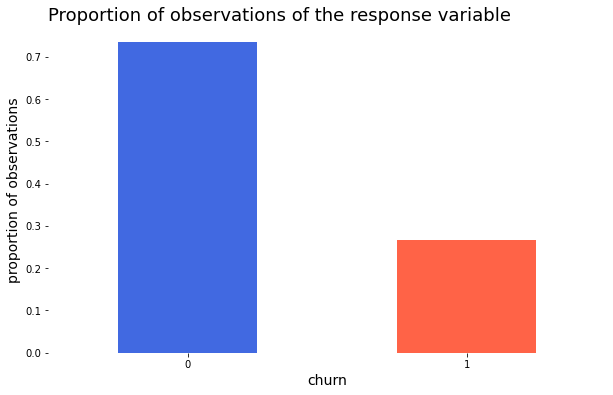

In [38]:

# create a figure
fig = plt.figure(figsize=(10, 6)) 
ax = fig.add_subplot(111)

# proportion of observation of each class
prop_response = df_telco['enddate'].value_counts(normalize=True)

# create a bar plot showing the percentage of churn
prop_response.plot(kind='bar', 
                   ax=ax,
                   color=['royalblue','tomato'])

# set title and labels
ax.set_title('Proportion of observations of the response variable',
             fontsize=18, loc='left')
ax.set_xlabel('churn',
              fontsize=14)
ax.set_ylabel('proportion of observations',
              fontsize=14)
ax.tick_params(rotation='auto')

# eliminate the frame from the plot
spine_names = ('top', 'right', 'bottom', 'left')
for spine_name in spine_names:
    ax.spines[spine_name].set_visible(False)

<div  style="border: solid black 2px; padding: 20px"> <b> Note:</b>
We can infer that the target is imbalnced 

##### Demographic Information <a class="anchor" id="Demographic"></a>

In [39]:
def percentage_stacked_plot(columns_to_plot, super_title):
    
    '''
    Prints a 100% stacked plot of the response variable for independent variable of the list columns_to_plot.
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization
            Returns:
                    None
    '''
    
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=.95)
 

    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(df_telco[column], df_telco['enddate']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0, color=['royalblue','tomato'])

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title('Proportion of observations by ' + column,
                     fontsize=16, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

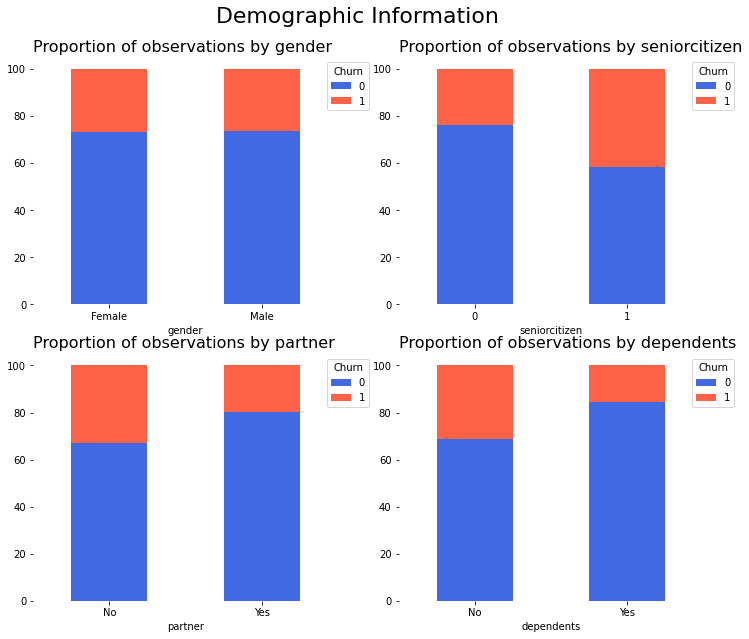

In [40]:
# demographic column names
demographic_columns = ['gender', 'seniorcitizen', 'partner', 'dependents']

# stacked plot of demographic columns
percentage_stacked_plot(demographic_columns, 'Demographic Information')

<div  style="border: solid black 2px; padding: 20px"> <b> </b>

We can extract the following conclusions by analyzing demographic attributes:

* The churn rate of senior citizens is almost double that of young citizens.
* We do not expect gender to have significant predictive power. A similar percentage of churn is shown both when a customer is a man or a woman.
* Customers with a partner churn less than customers with no partner.

##### Customer Account Information — Categorical variables <a class="anchor" id="CustomerAccount"></a>

In [41]:
#As shown below, some payment method denominations contain in parenthesis the word automatic. 
#These denominations are too long to be used as tick labels in further visualizations. 
#Therefore, we remove this clarification in parenthesis from the entries of the PaymentMethod column.
df_telco['paymentmethod'] = df_telco['paymentmethod'].str.replace(' (automatic)', '', regex=False)


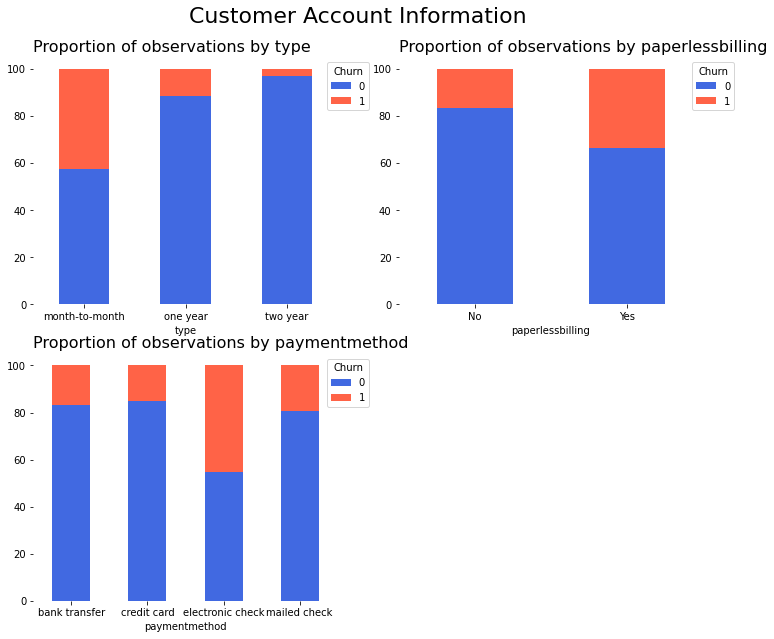

In [42]:

# customer account column names
account_columns = ['type', 'paperlessbilling', 'paymentmethod']

# stacked plot of customer account columns
percentage_stacked_plot(account_columns, 'Customer Account Information')

<div  style="border: solid black 2px; padding: 20px">

We can extract the following conclusions by analyzing Customer Account Information — Categorical variables:
* two -year contracts are less likely to churn
* month to month contracts are more likely to churn
* paper billing has no clear influence on churn
* electronic check payment methods are likely to churn more than other payment methods  

##### Customer Account Information — Numerical variables <a class="anchor" id="CustomerAccountNumerical"></a>

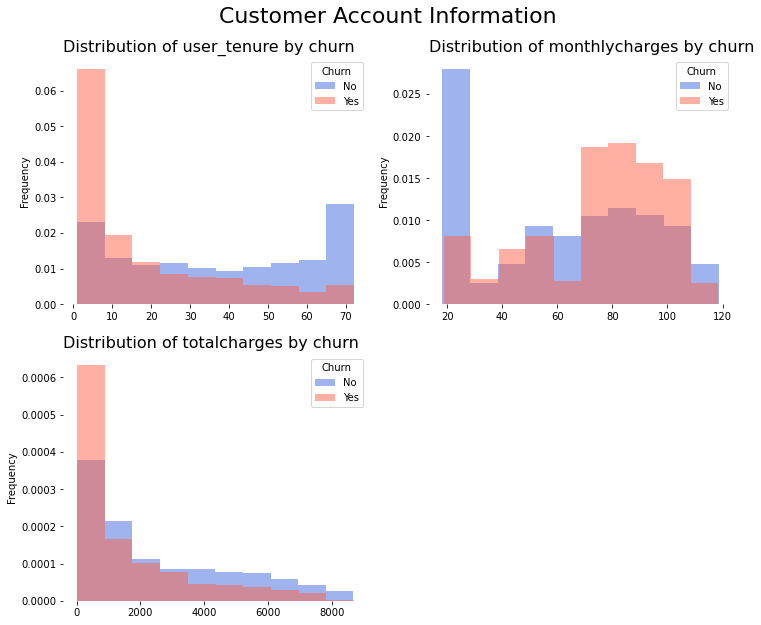

In [43]:
def histogram_plots(columns_to_plot, super_title):
    # set number of rows and number of columns
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=.95)
 

    # loop to each demographic column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # histograms for each class (normalized histogram)
        df_telco[df_telco['enddate']==0][column].plot(kind='hist', ax=ax, density=True, 
                                                       alpha=0.5, color='royalblue', label='No')
        df_telco[df_telco['enddate']==1][column].plot(kind='hist', ax=ax, density=True,
                                                        alpha=0.5, color='tomato', label='Yes')
        
        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title('Distribution of ' + column + ' by churn',
                     fontsize=16, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)
            
# customer account column names
account_columns_numeric = ['user_tenure', 'monthlycharges', 'totalcharges']
# histogram of costumer account columns 
histogram_plots(account_columns_numeric, 'Customer Account Information')

<div  style="border: solid black 2px; padding: 20px"> 
We can extract the following conclusions by analyzing the histograms for Numerical variables :

    * The churn rate tends to be larger when monthly charges are high.
    * New customers (low tenure) are more likely to churn.
    * Customers with high total charges are less likely to leave the company.

##### Services Information <a class="anchor" id="ServicesInformation"></a>


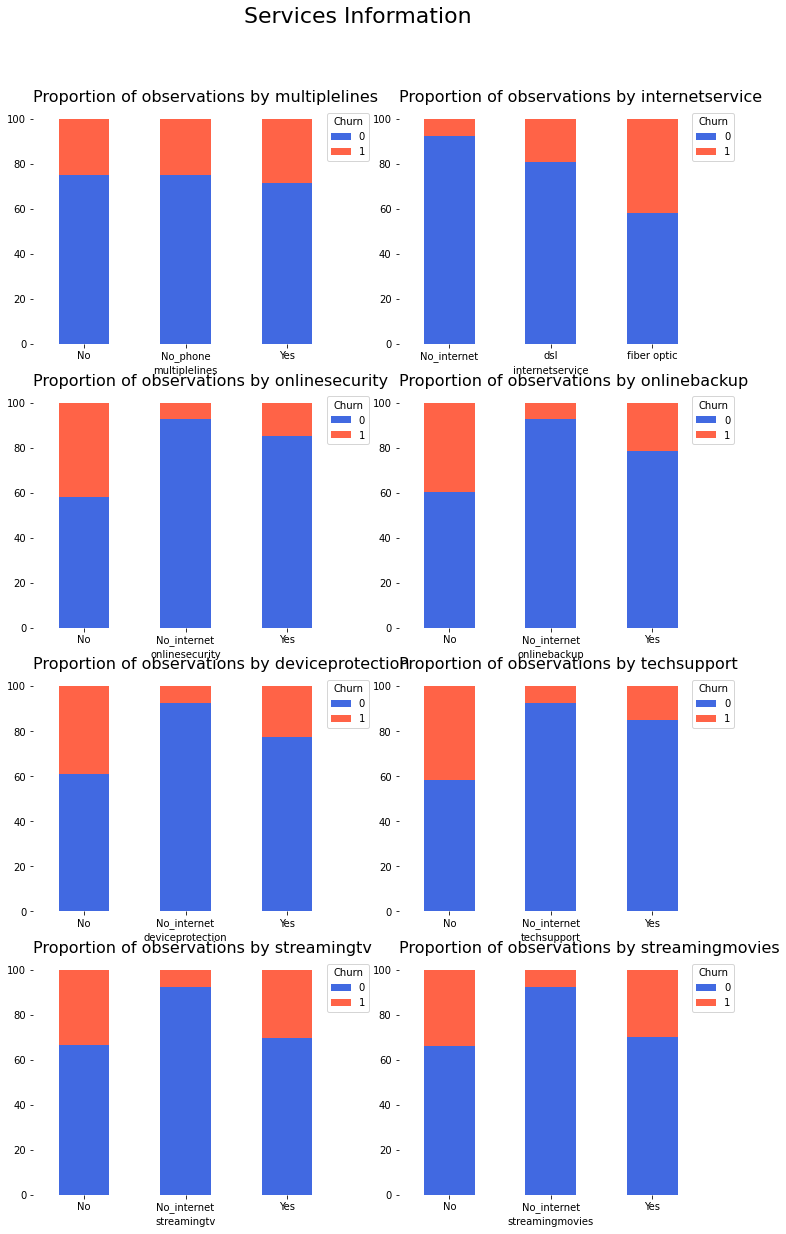

In [44]:
# services column names
services_columns = [
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies']

# stacked plot of services columns
percentage_stacked_plot(services_columns, 'Services Information')

<div  style="border: solid black 2px; padding: 20px"> 
We can extract the following conclusions by analyzing Services Information:
    
* multiple lines has no influence on churn
* different internet service - (fiber, DSL, no internet) influences churn
* different internet security influences churn
* different online backup security has an influence on churn
* different online tech support has an influence on churn
* streaming services have no clear influence. 

##### Feature importance <a class="anchor" id="Featureimportance"></a>

In [45]:
def compute_mutual_information(categorical_serie):
    return metrics.mutual_info_score(categorical_serie, df_telco.enddate)

# select categorial variables excluding the response variable 
categorical_variables = df_telco
categorical_variables = df_telco.drop(['enddate','customerid'], axis=1)

# compute the mutual information score between each categorical variable and the target
feature_importance = categorical_variables.apply(compute_mutual_information).sort_values(ascending=False).reset_index()
feature_importance.columns = ['feature','importance']
feature_importance.sort_values(by='importance')
# visualize feature importance
print(feature_importance)

             feature  importance
0         churn_date    0.579021
1       totalcharges    0.537530
2     monthlycharges    0.173835
3               type    0.098182
4          begindate    0.092840
5        user_tenure    0.078950
6     onlinesecurity    0.064528
7        techsupport    0.062873
8    internetservice    0.055394
9       onlinebackup    0.046659
10     paymentmethod    0.044423
11  deviceprotection    0.043784
12   streamingmovies    0.031918
13       streamingtv    0.031803
14  paperlessbilling    0.019119
15        dependents    0.014270
16           partner    0.011383
17     seniorcitizen    0.010533
18     multiplelines    0.000798
19            gender    0.000037


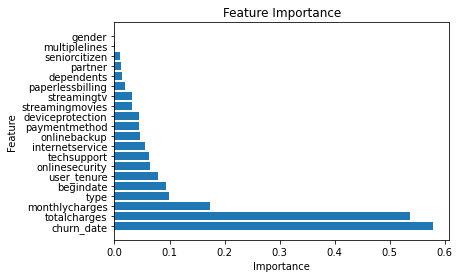

In [46]:

plt.barh(feature_importance['feature'],feature_importance['importance'])
plt.title('Feature Importance')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()


<div  style="border: solid black 2px; padding: 20px"> 
We can extract the following conclusions by analyzing the graph above:
    
* The features: gender, multiple lines, senior citizen, partner, and dependent has the lowest importance to the target
* the features: charges: monthly or total has the highest importance to the target  

moving forward:
* The features begin date, churn_date will be removed, as they can cause data leakage.
* In addition, only trial and error will determine which feature can or can not have an influence on the model roc_auc value. Hence, for now, all the features will stay and later might be removed.

##### customer exception<a class="anchor" id="customerexception"></a>

some customers registered for the services a month before the data was collected. Therefore they will be removed, as they do not represent correctly the real customers that left after one month.

In [47]:
df_telco2=df_telco.copy()
df_telco2=df_telco2.query('begindate<"2020-01-01"')

print(df_telco.shape)
print(df_telco2.shape)

(7032, 22)
(6799, 22)


In [48]:
(7032-6799)/7032

0.03313424345847554

less than 10% is acceptable

## Work Plan<a class="anchor" id='Work_Plan'></a>

**A list of clarifying questions:**
* can I use customedr_left - a feature that has 0 for 'No' and 1 for the date, as the target instead of end-date?
* should I get rid of some of the features - mainly the ones that don't have any correlation with end-date/customer left? for example type of subscription: month to month and one-two years are important features and should be part of the model while having dependents does not correlate with the customer leaving or staying. 
* the target and some features are unbalanced - should I use sampling or downsampling? 


**A rough plan for solving the task:**

this is a classification problem - the target is end date - 'No' and date or - 0 and 1.

* I'll drop the unnecessary features - the ones that do not correlate at all with the target, and dates. 
* I'll split the data set into the training set and test set and scale the data - the monthly charges and total charges are in a different range from the other.
* I'll test different models - random forest classifier and gradient boost - using cross validation. 
* I'll choose the best one - best AUC-ROC and Accuracy and will try to improve it by upsampling or downsampling.
* I'll test the model on the test set with linear calssification. 


## Prepare data for machine learning<a class="anchor" id="Prepare"></a>


### Feature Engineering<a class="anchor" id="Engineering"></a>

**No modification**

The seniorcitizen feature is already a binary column and should not be modified.

#### Label Encoding<a class="anchor" id="LabelEncoding"></a>


Label encoding is used to replace categorical values with numerical values. This encoding replaces every category with a numerical label. In this project, we use label encoding with the following binary variables: 'gender', 'partner', 'dependents', 'paperlessbilling'.

And, using Label encoding for services, where there are more than two variables.

In [49]:
label_encoding_columns =  ['gender', 'partner', 'dependents', 'paperlessbilling']
for column in label_encoding_columns:
    if column == 'gender':
        df_telco2[column] = df_telco2[column].map({'Female': 1, 'Male': 0})
    else: 
        df_telco2[column] = df_telco2[column].map({'Yes': 1, 'No': 0}) 

In [50]:
services_columns

['multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies']

In [51]:
encoder = OrdinalEncoder()
encoder.fit_transform(df_telco2[services_columns])
df_telco2[services_columns] = encoder.transform(df_telco2[services_columns])

In [52]:
df_telco2[services_columns]= df_telco2[services_columns].astype(int)

In [53]:
#checking for missing values
report = df_telco2.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df_telco2.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

missing_values  % of total
customerid                     0         0.0
begindate                      0         0.0
churn_date                     0         0.0
multiplelines                  0         0.0
streamingmovies                0         0.0
streamingtv                    0         0.0
techsupport                    0         0.0
deviceprotection               0         0.0
onlinebackup                   0         0.0
onlinesecurity                 0         0.0
internetservice                0         0.0
dependents                     0         0.0
partner                        0         0.0
seniorcitizen                  0         0.0
gender                         0         0.0
totalcharges                   0         0.0
monthlycharges                 0         0.0
paymentmethod                  0         0.0
paperlessbilling               0         0.0
type                           0         0.0
enddate                        0         0.0
user_tenure                    0         0.0

#### One-Hot Encoding<a class="anchor" id="One-HotEncoding"></a>

One-hot encoding creates a new binary column for each level of the categorical variable. The new column contains zeros and ones indicating the absence or presence of the category in the data.

In this project, we apply one-hot encoding to the following categorical features: 'type', 'paymentmethod'

In [54]:
# one-hot encoding (categorical variables with more than two levels)
one_hot_encoding_columns = ['type','paymentmethod']

# encode categorical variables with more than two levels using one-hot encoding
df_telco2 = pd.get_dummies(df_telco2, columns = one_hot_encoding_columns)


In [55]:
#checking for missing values
report = df_telco2.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df_telco2.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

missing_values  % of total
customerid                                   0         0.0
techsupport                                  0         0.0
paymentmethod_electronic check               0         0.0
paymentmethod_credit card                    0         0.0
paymentmethod_bank transfer                  0         0.0
type_two year                                0         0.0
type_one year                                0         0.0
type_month-to-month                          0         0.0
user_tenure                                  0         0.0
churn_date                                   0         0.0
multiplelines                                0         0.0
streamingmovies                              0         0.0
streamingtv                                  0         0.0
deviceprotection                             0         0.0
begindate                                    0         0.0
onlinebackup                                 0         0.0
onlinesecurity                               0         0.0
internetservice                              0         0.0
dependents                                   0         0.0
partner                                      0         0.0
seniorcitizen                                0         0.0
gender                                       0         0.0
totalcharges                                 0         0.0
monthlycharges                               0         0.0
paperlessbilling                             0         0.0
enddate                                      0         0.0
paymentmethod_mailed check                   0         0.0

### checking for outliers<a class="anchor" id="outliers"></a>

outliers may influence the models and skew the result. However, excluding outliers may not always be the best approach. only trial and error can show the real effect on the models. 

In [56]:
begindate = df_telco2.groupby('begindate')['customerid'].count().reset_index()
begindate = begindate.sort_values(by='customerid',ascending=False)
begindate

begindate  customerid
4  2014-02-01         366
71 2019-09-01         237
73 2019-11-01         237
72 2019-10-01         237
74 2019-12-01         220
..        ...         ...
37 2016-11-01          50
3  2014-01-01           7
2  2013-12-01           3
0  2013-10-01           3
1  2013-11-01           2

[75 rows x 2 columns]

In [57]:
begindate = df_telco2.groupby('begindate')['customerid'].count().reset_index()
begindate = begindate.sort_values(by='begindate')
begindate.head(20)

begindate  customerid
0  2013-10-01           3
1  2013-11-01           2
2  2013-12-01           3
3  2014-01-01           7
4  2014-02-01         366
5  2014-03-01         178
6  2014-04-01         114
7  2014-05-01          98
8  2014-06-01          97
9  2014-07-01          98
10 2014-08-01          82
11 2014-09-01          72
12 2014-10-01          80
13 2014-11-01          77
14 2014-12-01          75
15 2015-01-01          75
16 2015-02-01          80
17 2015-03-01          58
18 2015-04-01          69
19 2015-05-01          74

### spliting the data<a class="anchor" id="spliting"></a>

In [58]:
#removing features that may cause data leakage and the customerid - The customerID column is useless to explain whether not the customer will churn.
data_ml=df_telco2.copy() 

data_ml = data_ml.drop(['customerid','begindate','churn_date'],axis=1)

In [59]:
df_train, df_test = train_test_split(data_ml, test_size=0.25, random_state=12345)

In [60]:

target_train = df_train['enddate']
target_test = df_test['enddate']
print("target_train:",target_train.shape)
print("target_test:",target_test.shape)
features_train = df_train.drop('enddate',axis=1)
features_test = df_test.drop('enddate',axis=1)
print("features_train:",features_train.shape)
print("features_test:",features_test.shape)

target_train: (5099,)
target_test: (1700,)
features_train: (5099, 23)
features_test: (1700, 23)


In [61]:
target_train.shape

(5099,)

In [62]:
features_train.shape

(5099, 23)

## models<a class="anchor" id="models"></a>

In [64]:
#creat a function to evaluate tbe models
def evaluate_model(features,target,name,model):


# Run classifier with cross-validation and plot ROC curves
    X= features
    y = target
    scaler = MinMaxScaler()
    cv = StratifiedKFold(n_splits=5)
    classifier = model
    skf = StratifiedKFold(n_splits=5)
    skf.get_n_splits(X, y)
    #tprs = []
    #aucs = []
    #mean_fpr = np.linspace(0, 1, 100)
    X= features_train
    y = target_train
    roc_auc_scores=[]
    accuracys= []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, valid) in enumerate(cv.split(X, y)):
        X_train= X.iloc[train]
        X_valid = X.iloc[valid]
        X_train_scale =  pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
        X_valid_scale =  pd.DataFrame(scaler.transform(X_valid), columns = X_train.columns)
        classifier.fit(X_train_scale, y.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_valid_scale,
            y.iloc[valid],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        probabilities_test= classifier.predict_proba(X_valid_scale)
        probabilities_one_test= probabilities_test[:, 1]
        accuracy=metrics.accuracy_score(y.iloc[valid], probabilities_one_test.round())
        accuracys.append(accuracy)
        roc_auc_scores.append(roc_auc_score(y.iloc[valid], probabilities_one_test))


    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=name,
    )
    ax.legend(loc="lower right")
    plt.show()
    print('Average auc_roc cross validation score for model:', name, mean(roc_auc_scores))
    print('Average accuracys cross validation score for model:',name,mean(accuracys))




### Random forest classfier<a class="anchor" id="Randomforest"></a>

In [65]:
#Create function to train and fit models using GridSearchCV
def train_fit_score(model, params, name,scoring):
    model = GridSearchCV(model, param_grid=params, cv=5, scoring=scoring, verbose=10, refit=True)
    model.fit(features_train, target_train)
    return pd.DataFrame([[name, abs(model.best_score_), model.best_params_]], columns=['Estimator', 'Best Score', 'Best Params'])

In [75]:
%%capture
pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=12345,class_weight='balanced'))])
params_rf = { 'rf__n_estimators': range(100,200,25),'rf__max_depth' : range(1, 10, 1)}
RandomForest = train_fit_score(pipe_rf, params_rf, 'RandomForestClassifier',scoring='roc_auc')
print(list(RandomForest['Best Params']))

In [76]:
RandomForest

Estimator  Best Score  \
0  RandomForestClassifier    0.869596   

                                     Best Params  
0  {'rf__max_depth': 6, 'rf__n_estimators': 175}

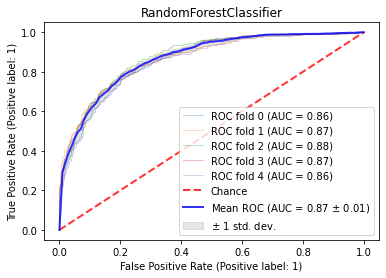

Average auc_roc cross validation score for model: RandomForestClassifier 0.8692561819365204
Average accuracys cross validation score for model: RandomForestClassifier 0.7848598202774731


In [77]:
evaluate_model(features_train,target_train,'RandomForestClassifier',RandomForestClassifier(max_depth=7, n_estimators= 175,random_state=12345,class_weight='balanced'))

### Gradient Boosting<a class="anchor" id="GradientBoosting"></a>

#### Gradient Boosting Classifier<a class="anchor" id="GradientBoostingClassifier"></a>

In [78]:
%%capture
pipe_gbc = Pipeline([('gbc',GradientBoostingClassifier())])
params_gbc = {'gbc__n_estimators': [80, 90, 100, 110, 115, 120],
                   'gbc__max_depth': [3, 4, 5, 6],
                   'gbc__max_features': [None, 'auto', 'sqrt', 'log2'], 
                   'gbc__min_samples_split': [2, 3, 4, 5,6,7,8,9,10]}
GradientBoosting = train_fit_score(pipe_gbc, params_gbc, 'GradientBoostingClassifier',scoring='roc_auc')
print(list(GradientBoosting['Best Params']))

In [79]:
GradientBoosting

Estimator  Best Score  \
0  GradientBoostingClassifier    0.870422   

                                         Best Params  
0  {'gbc__max_depth': 3, 'gbc__max_features': 'sq...

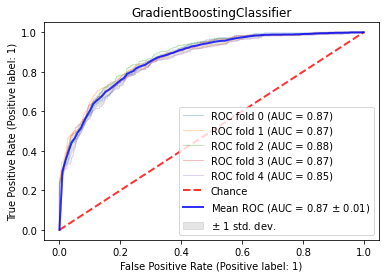

Average auc_roc cross validation score for model: GradientBoostingClassifier 0.8691589002803689
Average accuracys cross validation score for model: GradientBoostingClassifier 0.8164332582885951


In [80]:
evaluate_model(features_train,target_train,'GradientBoostingClassifier',GradientBoostingClassifier(max_depth= 3, max_features= 'log2', min_samples_split= 5, n_estimators= 90))

#### Lightgbm Classifier<a class="anchor" id="LightgbmClassifier"></a>

In [81]:
%%capture
pipe_lgb = Pipeline([('lgb',lgb.LGBMClassifier())])
params_lgb = {'lgb__task' : ['predict'],
     'lgb__boosting': ['gbdt' ],
     'lgb__num_iterations': range(50,200,50),
    'lgb__num_leaves':range(10,100,20),
    'lgb__max_depth' :range(10,100,20),
    'lgb__class_weight':['balanced'],
    'lgb__learning_rate':[0.1,0.2,0.3,0.4]}

lgbmClassifier = train_fit_score(pipe_lgb, params_lgb, 'LGBMClassifier',scoring='roc_auc')
print(list(lgbmClassifier['Best Params']))

In [82]:
lgbmClassifier

Estimator  Best Score  \
0  LGBMClassifier    0.869299   

                                         Best Params  
0  {'lgb__boosting': 'gbdt', 'lgb__class_weight':...

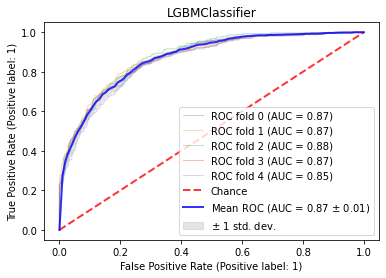

Average auc_roc cross validation score for model: LGBMClassifier 0.8694265493577125
Average accuracys cross validation score for model: LGBMClassifier 0.7764257538147742


In [83]:
evaluate_model(features_train,target_train,'LGBMClassifier',lgb.LGBMClassifier(class_weight= 'balanced', learning_rate= 0.1, max_depth= 10, num_iterations= 50, num_leaves= 10, task= 'predict'))

#### CatBoost Classifier<a class="anchor" id="CatBoostClassifier"></a>

In [84]:
%%capture
pipe_cbr = Pipeline([('cb',cb.CatBoostClassifier())])
params_cbr = {'cb__iterations': range(50,200,50),'cb__max_depth' : range(4,20,4),'cb__learning_rate' : [0.01,0.02,0.03,0.04]}

CatBoostClassifier = train_fit_score(pipe_cbr, params_cbr, 'CatBoostClassifier',scoring='roc_auc')
print(list(CatBoostClassifier['Best Params']))

0:	learn: 0.6870635	total: 157ms	remaining: 7.71s
1:	learn: 0.6795610	total: 158ms	remaining: 3.8s
2:	learn: 0.6719680	total: 159ms	remaining: 2.5s
3:	learn: 0.6652369	total: 160ms	remaining: 1.84s
4:	learn: 0.6584708	total: 162ms	remaining: 1.45s
5:	learn: 0.6513505	total: 163ms	remaining: 1.19s
6:	learn: 0.6444765	total: 164ms	remaining: 1s
7:	learn: 0.6378092	total: 165ms	remaining: 865ms
8:	learn: 0.6317856	total: 166ms	remaining: 755ms
9:	learn: 0.6261581	total: 167ms	remaining: 668ms
10:	learn: 0.6200086	total: 168ms	remaining: 595ms
11:	learn: 0.6155770	total: 169ms	remaining: 535ms
12:	learn: 0.6114758	total: 170ms	remaining: 484ms
13:	learn: 0.6066695	total: 171ms	remaining: 440ms
14:	learn: 0.6010549	total: 172ms	remaining: 402ms
15:	learn: 0.5969022	total: 173ms	remaining: 368ms
16:	learn: 0.5923586	total: 174ms	remaining: 338ms
17:	learn: 0.5873539	total: 175ms	remaining: 312ms
18:	learn: 0.5830306	total: 176ms	remaining: 288ms
19:	learn: 0.5782028	total: 178ms	remaining: 2

In [85]:
CatBoostClassifier

Estimator  Best Score  \
0  CatBoostClassifier     0.87065   

                                         Best Params  
0  {'cb__iterations': 150, 'cb__learning_rate': 0...

0:	learn: 0.6693961	total: 1.28ms	remaining: 190ms
1:	learn: 0.6420129	total: 2.6ms	remaining: 193ms
2:	learn: 0.6164738	total: 3.72ms	remaining: 182ms
3:	learn: 0.5958688	total: 4.78ms	remaining: 174ms
4:	learn: 0.5816937	total: 5.77ms	remaining: 167ms
5:	learn: 0.5633979	total: 6.86ms	remaining: 165ms
6:	learn: 0.5490854	total: 7.87ms	remaining: 161ms
7:	learn: 0.5335385	total: 8.95ms	remaining: 159ms
8:	learn: 0.5230838	total: 10.1ms	remaining: 158ms
9:	learn: 0.5127385	total: 11.1ms	remaining: 155ms
10:	learn: 0.5034076	total: 12.2ms	remaining: 154ms
11:	learn: 0.4942418	total: 13.2ms	remaining: 152ms
12:	learn: 0.4869395	total: 14.3ms	remaining: 151ms
13:	learn: 0.4796166	total: 15.4ms	remaining: 149ms
14:	learn: 0.4707777	total: 16.4ms	remaining: 148ms
15:	learn: 0.4645333	total: 17.6ms	remaining: 147ms
16:	learn: 0.4592253	total: 18.6ms	remaining: 146ms
17:	learn: 0.4534796	total: 19.7ms	remaining: 144ms
18:	learn: 0.4486369	total: 20.8ms	remaining: 143ms
19:	learn: 0.4448439	to

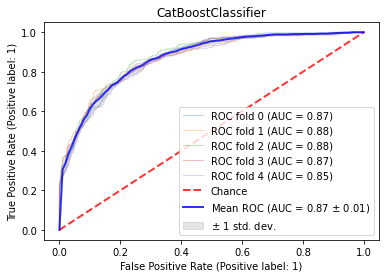

Average auc_roc cross validation score for model: CatBoostClassifier 0.8706502002228376
Average accuracys cross validation score for model: CatBoostClassifier 0.8170222632723354


In [90]:

evaluate_model(features_train,target_train,'CatBoostClassifier',cb.CatBoostClassifier(iterations= 150, learning_rate= 0.04, max_depth= 4))

<s>the models with the best accuracy and roc_auc value are GradientBoostingClassifier and CatBoostClassifier . 

### improving the model<a class="anchor" id="improving"></a>

The best two models are  Lightgbm Classifier and Gradient Boosting Classifier with 0.8783-7.Therefore, we will continue with one of them - the Gradient Boosting Classifier. 

the data is imbalanced, which has been mentioned before. therefore I'll try downsampling and upsampling to improve the mode. 

#### Resampling<a class="anchor" id="resampling"></a>

In [87]:

su = SMOTE(random_state=42)
X_su, y_su = su.fit_resample(features_train, target_train)

In [88]:
print(y_su.value_counts())


0    3670
1    3670
Name: enddate, dtype: int64


In [89]:
#Create function to train and fit models using GridSearchCV
def train_fit_score_up(model, params, name,scoring):
    model = GridSearchCV(model, param_grid=params, cv=5, scoring=scoring, verbose=10, refit=True)
    model.fit(X_su, y_su)
    return pd.DataFrame([[name, abs(model.best_score_), model.best_params_]], columns=['Estimator', 'Best Score', 'Best Params'])

In [91]:
%%capture
pipe_gbc_up = Pipeline([ ('gbc',GradientBoostingClassifier())])
params_gbc_up = {'gbc__n_estimators': [80, 90, 100, 110, 115, 120],
                   'gbc__max_depth': [3, 4, 5, 6],
                   'gbc__max_features': [None, 'auto', 'sqrt', 'log2'], 
                   'gbc__min_samples_split': [2, 3, 4, 5,6,7,8,9,10]}
GradientBoosting_up = train_fit_score_up(pipe_gbc_up, params_gbc, 'GradientBoostingClassifier',scoring='roc_auc')


In [99]:
print(list(GradientBoosting_up['Best Params']))

[{'gbc__max_depth': 4, 'gbc__max_features': None, 'gbc__min_samples_split': 8, 'gbc__n_estimators': 110}]


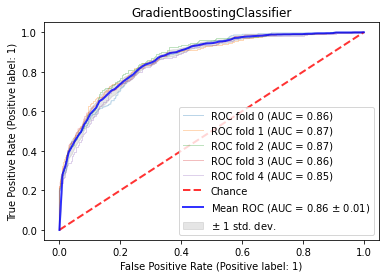

Average auc_roc cross validation score for model: GradientBoostingClassifier 0.8634126953881722
Average accuracys cross validation score for model: GradientBoostingClassifier 0.8129021147222383


In [100]:
evaluate_model(X_su, y_su,'GradientBoostingClassifier',GradientBoostingClassifier(max_depth= 4, max_features= None, min_samples_split= 8, n_estimators= 110))

In [102]:
pipe_cbr_up = Pipeline([('cb',cb.CatBoostClassifier())])
params_cbr_up = {'cb__iterations': range(50,200,50),'cb__max_depth' : range(4,20,4),'cb__learning_rate' : [0.01,0.02,0.03,0.04]}

CatBoostClassifier_up = train_fit_score_up(pipe_cbr_up, params_cbr_up, 'CatBoostClassifier',scoring='roc_auc')


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5; 1/48] START cb__iterations=50, cb__learning_rate=0.01, cb__max_depth=4.
0:	learn: 0.6886791	total: 1.47ms	remaining: 72.2ms
1:	learn: 0.6843255	total: 2.93ms	remaining: 70.3ms
2:	learn: 0.6774690	total: 4.49ms	remaining: 70.4ms
3:	learn: 0.6729397	total: 6.31ms	remaining: 72.6ms
4:	learn: 0.6661962	total: 8.05ms	remaining: 72.5ms
5:	learn: 0.6616614	total: 9.83ms	remaining: 72.1ms
6:	learn: 0.6573769	total: 11.6ms	remaining: 71.4ms
7:	learn: 0.6530306	total: 13.3ms	remaining: 69.9ms
8:	learn: 0.6486750	total: 15.2ms	remaining: 69.4ms
9:	learn: 0.6433135	total: 17ms	remaining: 67.8ms
10:	learn: 0.6394478	total: 18.5ms	remaining: 65.5ms
11:	learn: 0.6334749	total: 20.2ms	remaining: 64.1ms
12:	learn: 0.6287355	total: 22.2ms	remaining: 63.1ms
13:	learn: 0.6253878	total: 23.7ms	remaining: 61ms
14:	learn: 0.6218737	total: 25.3ms	remaining: 59.1ms
15:	learn: 0.6185073	total: 27ms	remaining: 57.3ms
16:	learn: 0.6151575	tota

In [103]:
print(list(CatBoostClassifier_up['Best Params']))

[{'cb__iterations': 150, 'cb__learning_rate': 0.04, 'cb__max_depth': 8}]


0:	learn: 0.6616506	total: 4.02ms	remaining: 599ms
1:	learn: 0.6333162	total: 6.21ms	remaining: 459ms
2:	learn: 0.6080612	total: 9.84ms	remaining: 482ms
3:	learn: 0.5852287	total: 13.6ms	remaining: 497ms
4:	learn: 0.5648615	total: 16.6ms	remaining: 482ms
5:	learn: 0.5480886	total: 20.8ms	remaining: 500ms
6:	learn: 0.5303950	total: 24.7ms	remaining: 504ms
7:	learn: 0.5166877	total: 29.1ms	remaining: 517ms
8:	learn: 0.5045900	total: 33.1ms	remaining: 518ms
9:	learn: 0.4933246	total: 37.9ms	remaining: 531ms
10:	learn: 0.4818462	total: 42.3ms	remaining: 534ms
11:	learn: 0.4722976	total: 46.3ms	remaining: 533ms
12:	learn: 0.4618261	total: 50.5ms	remaining: 532ms
13:	learn: 0.4546526	total: 55.2ms	remaining: 536ms
14:	learn: 0.4474493	total: 58.4ms	remaining: 526ms
15:	learn: 0.4400319	total: 62.5ms	remaining: 523ms
16:	learn: 0.4341539	total: 67.2ms	remaining: 526ms
17:	learn: 0.4281825	total: 71.5ms	remaining: 524ms
18:	learn: 0.4233134	total: 74.8ms	remaining: 516ms
19:	learn: 0.4182185	t

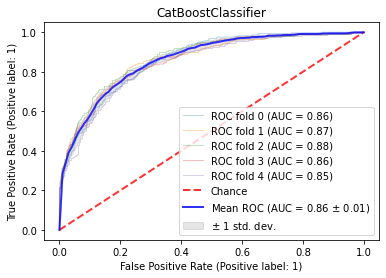

Average auc_roc cross validation score for model: CatBoostClassifier 0.8626841460083967
Average accuracys cross validation score for model: CatBoostClassifier 0.8109417152533241


In [104]:
evaluate_model(X_su, y_su,'CatBoostClassifier',cb.CatBoostClassifier(iterations= 150, learning_rate= 0.04, max_depth= 8))

The resampling did not improve the score

#### Eliminating features of less importance<a class="anchor" id="Eliminating"></a>

In [106]:
#removing features that may cause data leakage and the customerid - The customerID column is useless to explain whether not the customer will churn.
data_ml2=df_telco2.copy() 

data_ml2 = data_ml2.drop(['customerid','begindate','churn_date','dependents'],axis=1)

In [107]:
df_train2, df_test2 = train_test_split(data_ml2, test_size=0.25, random_state=12345)

In [108]:

target_train2 = df_train2['enddate']
target_test2 = df_test2['enddate']
print("target_train2:",target_train2.shape)
print("target_test:2",target_test2.shape)
features_train2 = df_train2.drop('enddate',axis=1)
features_test2 = df_test2.drop('enddate',axis=1)
print("features_train2:",features_train2.shape)
print("features_test2:",features_test2.shape)

target_train2: (5099,)
target_test:2 (1700,)
features_train2: (5099, 22)
features_test2: (1700, 22)


In [109]:
#Create function to train and fit models using GridSearchCV
def train_fit_score2(model, params, name,scoring):
    model = GridSearchCV(model, param_grid=params, cv=5, scoring=scoring, verbose=10, refit=True)
    model.fit(features_train2, target_train2)
    return pd.DataFrame([[name, abs(model.best_score_), model.best_params_]], columns=['Estimator', 'Best Score', 'Best Params'])

In [110]:
%%capture
pipe_gbc_2 = Pipeline([('gbc',GradientBoostingClassifier())])
params_gbc_2 = {'gbc__n_estimators': [80, 90, 100, 110, 115, 120],
                   'gbc__max_depth': [3, 4, 5, 6],
                   'gbc__max_features': [None, 'auto', 'sqrt', 'log2'], 
                   'gbc__min_samples_split': [2, 3, 4, 5,6,7,8,9,10]}
GradientBoosting_2 = train_fit_score2(pipe_gbc_2, params_gbc_2, 'GradientBoostingClassifier',scoring='roc_auc')


In [111]:
print(list(GradientBoosting_2['Best Params']))

[{'gbc__max_depth': 3, 'gbc__max_features': 'sqrt', 'gbc__min_samples_split': 6, 'gbc__n_estimators': 80}]


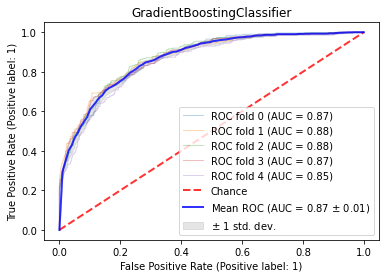

Average auc_roc cross validation score for model: GradientBoostingClassifier 0.8697486876620678
Average accuracys cross validation score for model: GradientBoostingClassifier 0.8162360253227886


In [112]:
evaluate_model(features_train2, target_train2,'GradientBoostingClassifier',GradientBoostingClassifier(max_depth= 3, max_features= 'sqrt', min_samples_split= 10, n_estimators= 80))

In [113]:
%%capture
pipe_cbr2 = Pipeline([('cb',cb.CatBoostClassifier())])
params_cbr2 = {'cb__iterations': [100,150,200],'cb__max_depth' : [4,16],'cb__learning_rate' : [0.01,0.02,0.03,0.04],"cb__border_count":[100,200]}

CatBoostClassifier2 = train_fit_score2(pipe_cbr2, params_cbr2, 'CatBoostClassifier',scoring='roc_auc')


0:	learn: 0.6868409	total: 1.26ms	remaining: 125ms
1:	learn: 0.6797056	total: 2.73ms	remaining: 134ms
2:	learn: 0.6725119	total: 4.03ms	remaining: 130ms
3:	learn: 0.6658415	total: 5.24ms	remaining: 126ms
4:	learn: 0.6585067	total: 6.57ms	remaining: 125ms
5:	learn: 0.6515559	total: 7.69ms	remaining: 120ms
6:	learn: 0.6462863	total: 8.93ms	remaining: 119ms
7:	learn: 0.6399837	total: 10ms	remaining: 116ms
8:	learn: 0.6341222	total: 11.1ms	remaining: 113ms
9:	learn: 0.6278443	total: 12.2ms	remaining: 110ms
10:	learn: 0.6227160	total: 13.2ms	remaining: 107ms
11:	learn: 0.6172108	total: 14.3ms	remaining: 105ms
12:	learn: 0.6121484	total: 15.4ms	remaining: 103ms
13:	learn: 0.6064641	total: 16.4ms	remaining: 101ms
14:	learn: 0.6019150	total: 17.4ms	remaining: 98.6ms
15:	learn: 0.5974538	total: 18.4ms	remaining: 96.6ms
16:	learn: 0.5921262	total: 19.4ms	remaining: 94.6ms
17:	learn: 0.5878017	total: 20.3ms	remaining: 92.5ms
18:	learn: 0.5828528	total: 21.3ms	remaining: 90.8ms
19:	learn: 0.579056

In [114]:
print(list(CatBoostClassifier2['Best Params']))

[{'cb__border_count': 100, 'cb__iterations': 200, 'cb__learning_rate': 0.03, 'cb__max_depth': 4}]


0:	learn: 0.6751946	total: 1.14ms	remaining: 228ms
1:	learn: 0.6540093	total: 2.38ms	remaining: 236ms
2:	learn: 0.6336967	total: 3.48ms	remaining: 229ms
3:	learn: 0.6167843	total: 4.55ms	remaining: 223ms
4:	learn: 0.6043152	total: 5.58ms	remaining: 218ms
5:	learn: 0.5891870	total: 6.65ms	remaining: 215ms
6:	learn: 0.5760328	total: 7.74ms	remaining: 213ms
7:	learn: 0.5656689	total: 8.73ms	remaining: 210ms
8:	learn: 0.5542297	total: 9.8ms	remaining: 208ms
9:	learn: 0.5422077	total: 10.9ms	remaining: 206ms
10:	learn: 0.5305190	total: 11.9ms	remaining: 205ms
11:	learn: 0.5234144	total: 12.9ms	remaining: 202ms
12:	learn: 0.5158569	total: 13.9ms	remaining: 200ms
13:	learn: 0.5080598	total: 15ms	remaining: 199ms
14:	learn: 0.5008135	total: 16.1ms	remaining: 198ms
15:	learn: 0.4943914	total: 17.4ms	remaining: 200ms
16:	learn: 0.4893617	total: 18.5ms	remaining: 199ms
17:	learn: 0.4821506	total: 19.6ms	remaining: 198ms
18:	learn: 0.4772954	total: 20.7ms	remaining: 197ms
19:	learn: 0.4727452	tota

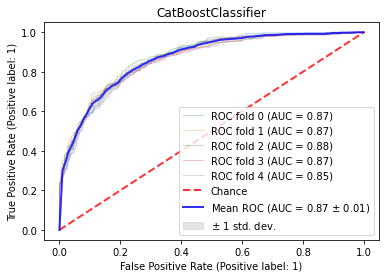

Average auc_roc cross validation score for model: CatBoostClassifier 0.8704929319449612
Average accuracys cross validation score for model: CatBoostClassifier 0.8193744347591834


In [115]:
evaluate_model(features_train2, target_train2,'CatBoostClassifier',cb.CatBoostClassifier(iterations= 200, learning_rate= 0.03, max_depth= 4,border_count=100))

## Testing the models with the test set

Both the CatBoostClassifier and the GradientBoostingClassifier had very close, so I'll use them both for the test set.

In [116]:
#creat a function to evaluate tbe models
def test_model(model,X_test,y_test):
    
    probabilities_test= model.predict_proba(X_test)
    probabilities_one_test= probabilities_test[:, 1]

    auc_roc= roc_auc_score(y_test, probabilities_one_test)
    print(str(model))
    print('auc_roc score:', auc_roc)
    accuracy=accuracy_score(y_test, probabilities_one_test.round())
    print('accuracy',accuracy)

In [119]:
model_gbc_model2 = GradientBoostingClassifier(max_depth= 3, max_features= 'sqrt', min_samples_split= 10, n_estimators= 80)
model_gbc_model2.fit(features_train2, target_train2)
test_model(model_gbc_model2,features_test2, target_test2)

GradientBoostingClassifier(max_features='sqrt', min_samples_split=10,
                           n_estimators=80)
auc_roc score: 0.8803526334776335
accuracy 0.8370588235294117


In [120]:
model_gbc_model2 = cb.CatBoostClassifier(iterations= 200, learning_rate= 0.03, max_depth= 4,border_count=100)
model_gbc_model2.fit(features_train2, target_train2)
test_model(model_gbc_model2,features_test2, target_test2)

0:	learn: 0.6746170	total: 1.2ms	remaining: 239ms
1:	learn: 0.6546621	total: 2.54ms	remaining: 252ms
2:	learn: 0.6356538	total: 3.75ms	remaining: 247ms
3:	learn: 0.6209129	total: 5.04ms	remaining: 247ms
4:	learn: 0.6035903	total: 6.49ms	remaining: 253ms
5:	learn: 0.5874787	total: 7.96ms	remaining: 258ms
6:	learn: 0.5760427	total: 9.42ms	remaining: 260ms
7:	learn: 0.5642837	total: 10.7ms	remaining: 256ms
8:	learn: 0.5542164	total: 11.9ms	remaining: 252ms
9:	learn: 0.5438113	total: 13.1ms	remaining: 249ms
10:	learn: 0.5342935	total: 14.2ms	remaining: 244ms
11:	learn: 0.5269016	total: 15.3ms	remaining: 240ms
12:	learn: 0.5204868	total: 16.5ms	remaining: 237ms
13:	learn: 0.5118565	total: 17.7ms	remaining: 235ms
14:	learn: 0.5035073	total: 18.9ms	remaining: 233ms
15:	learn: 0.4971901	total: 20ms	remaining: 230ms
16:	learn: 0.4891798	total: 21.1ms	remaining: 228ms
17:	learn: 0.4832909	total: 22.2ms	remaining: 224ms
18:	learn: 0.4784639	total: 23.2ms	remaining: 221ms
19:	learn: 0.4720129	tota

<div  style="border: solid black 2px; padding: 20px"> 

The elimination of the features:  'dependents', 'partner' has provieded the best result for the roc_auc value - 0.881. 

### Baseline model for sanity check<a class="anchor" id='sanity'></a>

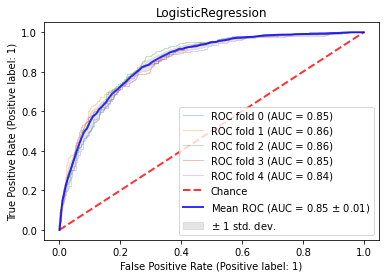

Average auc_roc cross validation score for model: LogisticRegression 0.8521495030615925
Average accuracys cross validation score for model: LogisticRegression 0.7540706959918413


In [121]:
evaluate_model(features_train2, target_train2,'LogisticRegression',LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced'))

In [123]:
model_lg = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model_lg.fit(features_train2, target_train2)
test_model(model_lg,features_test2, target_test2)

LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear')
auc_roc score: 0.8592027417027418
accuracy 0.7547058823529412


<div  style="border: solid black 2px; padding: 20px"> 
the baseline model for sanity check has a roc_auc  value of 0.858, which means the elimination of the two features and the other feature engineering was fitting.

## Conclusion<a class="anchor" id='Conclusion'></a>

In this project, we have walked through a complete end-to-end machine learning project using the Telco customer Churn dataset. We started by cleaning the data and analyzing it with visualization. Then, to be able to build a machine learning model, we transformed the categorical data into numeric variables (feature engineering). After transforming the data, we tried different machine learning algorithms using hyperparameters tuning. 
Although the roc_auc values of the CatBoostClassifier and Gradient Boosting Classifier were ~0.87, we still tried to improve the mode. First, we tried downsampling and upsampling, due to the imbalance of the target. these methods had no improvement to the model roc_auc value. The second approach was to eliminate one or two features that may or may not affect the model's roc_auc value. this approach seems to have the best effect on the roc_auc vale, since removing both of the 'dependents', and 'partner' features were the best approach. 
Finally, with a tuned of the Gradient Boosting Classifier and CatBoostClassifier (best performance models) with all the model optimizations, obtaining a roc_auc of more than 88% and accurcy score of ~82.



## Solution Report<a class="anchor" id='Solution'></a>

* What steps of the plan were performed and what steps were skipped (explain why)?
    * I'll drop the unnecessary features - the ones that do not correlate at all with the target, and dates. - done
    * I'll split the data set into the training set and test set and scale the data - the monthly charges and total charges are in a different range from the other. -done
    * I'll test different models - random forest classifier and gradient boost - using cross-validation. -done
    * I'll choose the best one - best AUC-ROC and Accuracy and will try to improve it by upsampling or downsampling. - I switch to resampling, as by imbalance library that the reviewer recommended. 
    * I'll test the model on the test set with linear classification. - done using logistic regression. 


* What difficulties did you encounter and how did you manage to solve them?

    The AUC did not improve using model parameters hyper-tuning and resampling. therefore I tried to find other ways to try to improve it. Using this article: https://www.linkedin.com/pulse/how-improve-auc-amanda-zou/?trackingId=qreB2Yh1WD9alafd3SbVnA%3D%3D I have found that I can improve the AUC value by removing some features. I have used the importance graph to choose which feature to choose and by trial and error, I have chosen the 'dependants' feature. 
    
    
* What were some of the key steps to solving the task?
    * Data Reading and Data Cleaning
    * EDA
    * Feature Engineering
    * Models parameters hyper-tuning
    * Improving the Model
    * Testing the best model with the test set
    * Baseline model for a sanity check


* What is your final model and what quality score does it have?

    the final mode is: CatBoostClassifier
    
    its quality score is accuracy: 0.8370588235294117 and roc_auc:0.8804419191919192
